<a href="https://colab.research.google.com/github/ruksad/Machine-learning/blob/master/deep_learning_gen_ai/epgd_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install kaggle


In [11]:
from google.colab import files
files.upload()   # upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ruksadsiddiqui","key":"9087d5d00b3e97657c1a59c526568592"}'}

In [12]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
!kaggle datasets download -d gopalbhattrai/pascal-voc-2012-dataset
!unzip pascal-voc-2012-dataset.zip -d VOC2012

Streaming output truncated to the last 5000 lines.
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001874.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001876.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001882.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001885.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001895.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001896.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001926.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001966.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001971.png  
  inflating: VOC2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001992.png  
  inflating: VOC201

In [14]:
import os
import shutil

src = "/content/VOC2012/VOC2012_train_val/VOC2012_train_val"
dst = "/content/VOCdevkit/VOC2012"

# Make parent folder
os.makedirs("/content/VOCdevkit", exist_ok=True)

# Move or copy the dataset to expected path
if not os.path.exists(dst):
    shutil.move(src, dst)   # or use shutil.copytree(src, dst)
    print(f"Moved dataset to {dst}")
else:
    print(f"Dataset already exists at {dst}")


Moved dataset to /content/VOCdevkit/VOC2012


https://arxiv.org/pdf/1802.02611

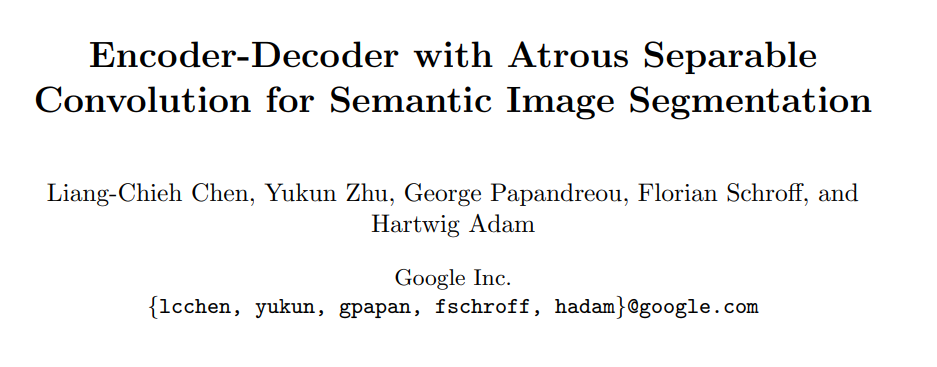

RESNET

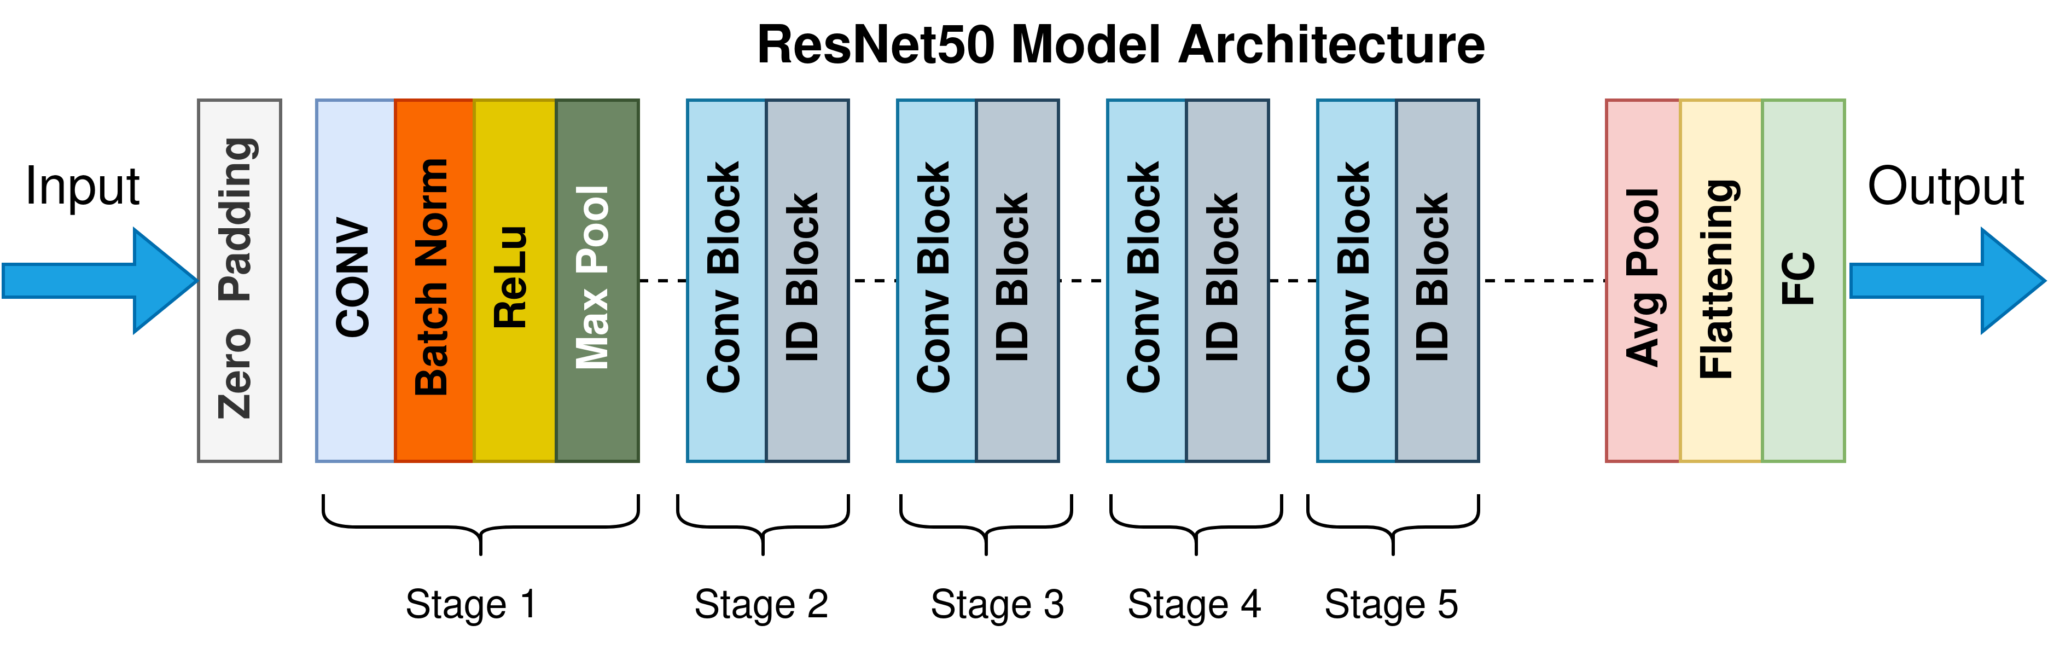

ARCHITECTURE

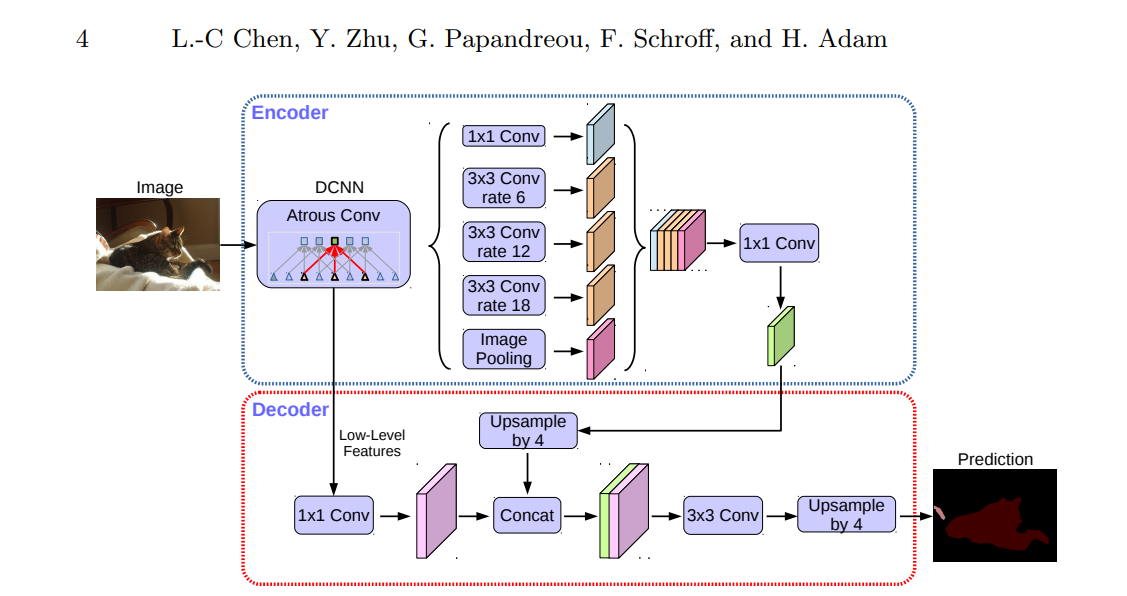

DILATED CONVOLUTION

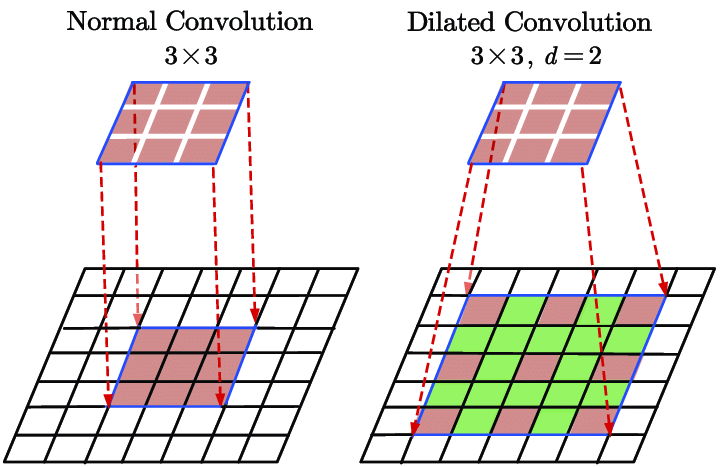

WORKFLOW

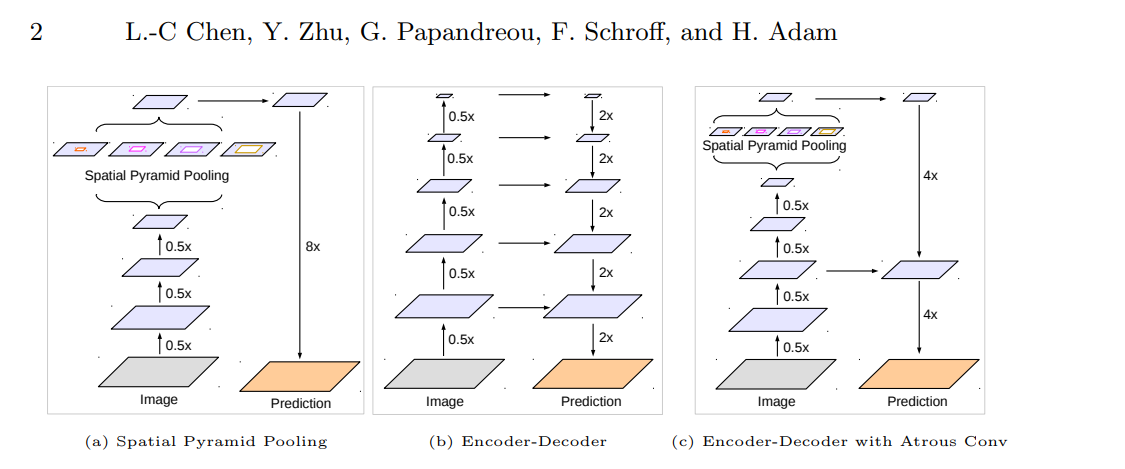

EXPERIMENT

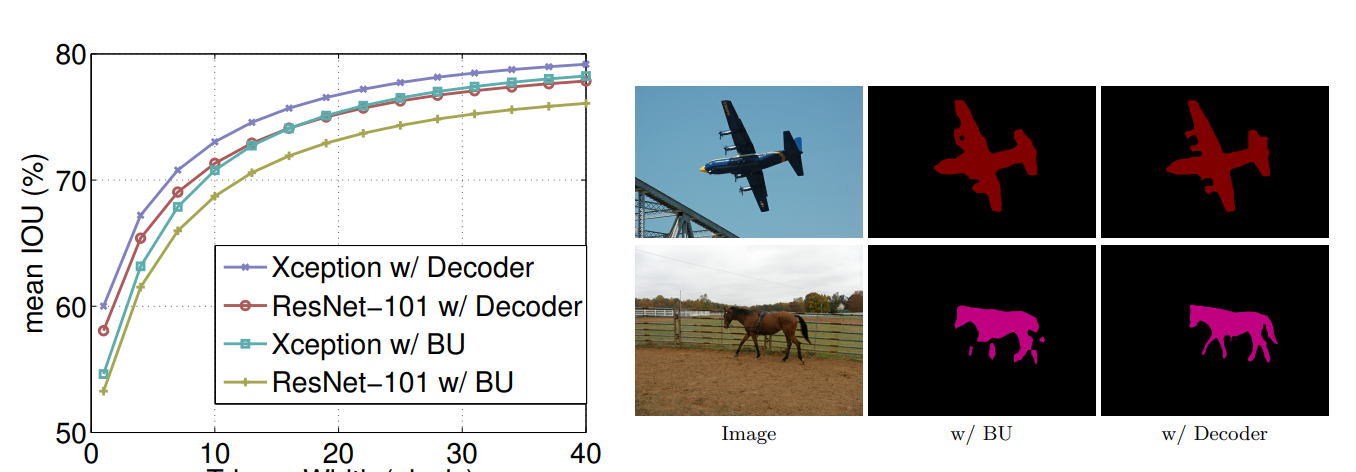

VISUALIZATION

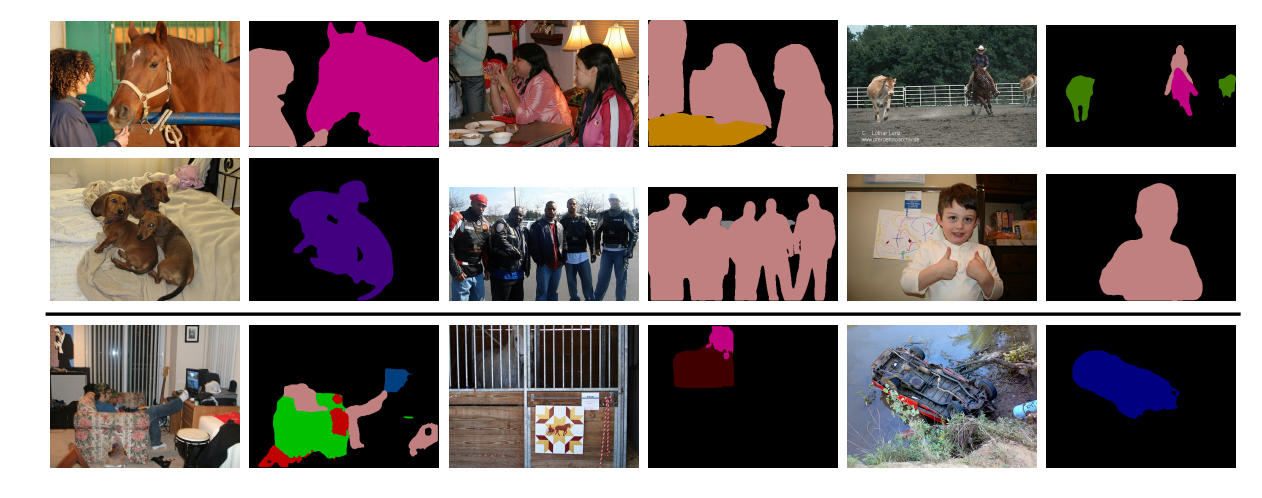

In [15]:
import os
import shutil
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

In [16]:
# -------------------------
# Repro / Device
# -------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Paths & data prep
# -------------------------
# If you ALREADY have the dataset, set this to the folder that contains VOC2012.
# For built-in downloader, leave DATA_ROOT="/content" (it will create /content/VOCdevkit/VOC2012)
DATA_ROOT = "/content"

# -------------------------
# Hyperparameters
# -------------------------
NUM_CLASSES = 21  # 20 classes + background
BATCH_SIZE = 6     # keep modest for Colab
LR = 1e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 25
CROP_SIZE = 513   # DeepLab uses 513 crop commonly
NUM_WORKERS = 2
PRINT_FREQ = 20
CHECKPOINT_DIR = "/content/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# -------------------------
# Transforms
# -------------------------
# Normalization for ImageNet pretrained backbone
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

# torchvision VOCSegmentation expects paired transforms; we’ll implement joint transforms.
#teaches the model scale invariance (objects can appear small or big).
class RandomResize:
    def __init__(self, min_size=320, max_size=720):
        self.min = min_size
        self.max = max_size
    def __call__(self, img, target):
        size = random.randint(self.min, self.max)
        img = T.functional.resize(img, size, interpolation=Image.BILINEAR)
        target = T.functional.resize(target, size, interpolation=Image.NEAREST)  #Takes the segmentation mask (class labels for each pixel) and resizes it to the same size.
        return img, target

#data augmentation  dog face left vs dog face right
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img, target):
        if random.random() < self.p:
            img = T.functional.hflip(img)
            target = T.functional.hflip(target)
        return img, target

class RandomCrop:
    def __init__(self, size):
        self.size = size
    def __call__(self, img, target):
        i, j, h, w = T.RandomCrop.get_params(img, output_size=(self.size, self.size))
        img = T.functional.crop(img, i, j, h, w)
        target = T.functional.crop(target, i, j, h, w)
        return img, target

class ToTensorNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, img, target):
        img = T.functional.to_tensor(img)
        img = T.functional.normalize(img, self.mean, self.std)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return img, target

class ValResizeCenterCrop:
    def __init__(self, size):
        self.size = size
    def __call__(self, img, target):
        img = T.functional.resize(img, self.size, interpolation=Image.BILINEAR)
        target = T.functional.resize(target, self.size, interpolation=Image.NEAREST)
        # center crop
        img = T.functional.center_crop(img, self.size)
        target = T.functional.center_crop(target, self.size)
        return img, target

train_joint = [
    RandomResize(CROP_SIZE, 720),   # i.e., RandomResize(513, 720)
    RandomHorizontalFlip(0.5),
    RandomCrop(CROP_SIZE),
]
val_joint = [
    ValResizeCenterCrop(CROP_SIZE),
]

to_tensor_norm = ToTensorNormalize(imagenet_mean, imagenet_std)

def train_transform(img, target):
    for t in train_joint:
        img, target = t(img, target)
    img, target = to_tensor_norm(img, target)
    return img, target

def val_transform(img, target):
    for t in val_joint:
        img, target = t(img, target)
    img, target = to_tensor_norm(img, target)
    return img, target


Device: cuda


In [17]:
# -------------------------
# Datasets & Loaders
# -------------------------
def target_transform(mask):
    # VOC uses 255 as ignore label. We keep it as is; CE loss will ignore it.
    return mask

train_set = VOCSegmentation(
    root=DATA_ROOT, year="2012", image_set="train",
    download=False, transforms=lambda img, m: train_transform(img, m)
)
val_set = VOCSegmentation(
    root=DATA_ROOT, year="2012", image_set="val",
    download=False, transforms=lambda img, m: val_transform(img, m)
)


print("Train images:", len(train_set), "Val images:", len(val_set))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)


Train images: 1464 Val images: 1449


In [18]:
# -------------------------
# Model: DeepLabv3-ResNet50
# -------------------------
model = deeplabv3_resnet50(weights="DEFAULT")  # pretrained on COCO
# Replace classifier head to match VOC classes (21)
#The final layer of DeepLabv3 is a 1×1 convolution that maps 256 channels → num_classes.
in_channels = model.classifier[-1].in_channels if hasattr(model.classifier[-1], "in_channels") else 256
model.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)

# Aux classifier provides extra gradients to mid-level layers → helps them learn better features. (optional helps training)
if model.aux_classifier is not None:
    model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)

model.to(device)

# -------------------------
# Optimizer, Loss, AMP
# -------------------------
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, total_steps=NUM_EPOCHS * len(train_loader), pct_start=0.1
)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# -------------------------
# Metrics
# -------------------------
def fast_confusion_matrix(pred, target, num_classes, ignore_index=255):
    # pred, target: [N, H, W]
    mask = target != ignore_index
    pred = pred[mask]
    target = target[mask]
    n = num_classes
    k = (target * n + pred).to(torch.int64)
    bincount = torch.bincount(k, minlength=n*n)
    return bincount.reshape(n, n)

#pixel accuracy=Is my model classifying pixels correctly overall?      actual correct /(actualcorrect +missed predn + wrong predn)
#iou=Is my model segmenting each class properly
def miou_and_pixel_acc(conf_mat):
    # conf_mat: [C, C], rows: ground truth, cols: prediction
    h = conf_mat.float()
    diag = torch.diag(h)
    gt_sum = h.sum(1)
    pred_sum = h.sum(0)
    union = gt_sum + pred_sum - diag
    iou = diag / (union + 1e-10)
    miou = iou.mean().item()
    pixel_acc = diag.sum().item() / (h.sum().item() + 1e-10)
    return miou, pixel_acc, iou.cpu().numpy()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 130MB/s]
/tmp/ipython-input-565302466.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


In [22]:
# -------------------------
# Training / Validation
# -------------------------
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=device) #confusion matrix
    for it, (images, targets) in enumerate(train_loader, 1):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(images)
            main_logits = outputs["out"]
            loss = criterion(main_logits, targets)
            if model.aux_classifier is not None and "aux" in outputs:
                aux_logits = outputs["aux"]
                loss = loss + 0.4 * criterion(aux_logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()

        running_loss += loss.item()

        with torch.no_grad():
            preds = main_logits.argmax(1)
            conf += fast_confusion_matrix(preds, targets, NUM_CLASSES, ignore_index=255)

        if it % PRINT_FREQ == 0:
            miou, pixacc, _ = miou_and_pixel_acc(conf)
            print(f"Epoch {epoch} | Iter {it}/{len(train_loader)} | "
                  f"loss {running_loss/it:.4f} | mIoU {miou*100:.2f}% | pixAcc {pixacc*100:.2f}%")

    miou, pixacc, _ = miou_and_pixel_acc(conf)
    return running_loss/len(train_loader), miou, pixacc


In [20]:
@torch.no_grad()
def validate(epoch):
    model.eval()
    conf = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=device)
    val_loss = 0.0
    for images, targets in val_loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(images)
            logits = outputs["out"]
            loss = criterion(logits, targets)
        val_loss += loss.item()
        preds = logits.argmax(1)
        conf += fast_confusion_matrix(preds, targets, NUM_CLASSES, ignore_index=255)
    val_loss /= len(val_loader)
    miou, pixacc, cls_iou = miou_and_pixel_acc(conf)
    print(f"[VAL] Epoch {epoch} | loss {val_loss:.4f} | mIoU {miou*100:.2f}% | pixAcc {pixacc*100:.2f}%")
    return val_loss, miou, pixacc, cls_iou

In [21]:
#-------------------------
# Train Loop
# -------------------------
best_miou = 0.0
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_miou, train_pix = train_one_epoch(epoch)
    val_loss, val_miou, val_pix, cls_iou = validate(epoch)

    # Save checkpoint
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"deeplabv3_resnet50_voc_e{epoch:03d}.pt")
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "miou": val_miou,
        "pixacc": val_pix,
        "val_loss": val_loss,
    }, ckpt_path)
    print("Saved:", ckpt_path)

    if val_miou > best_miou:
        best_miou = val_miou
        best_path = os.path.join(CHECKPOINT_DIR, "best.pt")
        shutil.copyfile(ckpt_path, best_path)
        print("** New best mIoU, checkpoint updated:", best_path)

print("Training done. Best mIoU:", best_miou*100, "%")

# -------------------------
# Quick Visualization
# -------------------------
# VOC color map
VOC_COLORMAP = np.array([
    [0,0,0],       # background
    [128,0,0],     # aeroplane
    [0,128,0],     # bicycle
    [128,128,0],   # bird
    [0,0,128],     # boat
    [128,0,128],   # bottle
    [0,128,128],   # bus
    [128,128,128], # car
    [64,0,0],      # cat
    [192,0,0],     # chair
    [64,128,0],    # cow
    [192,128,0],   # diningtable
    [64,0,128],    # dog
    [192,0,128],   # horse
    [64,128,128],  # motorbike
    [192,128,128], # person
    [0,64,0],      # potted plant
    [128,64,0],    # sheep
    [0,192,0],     # sofa
    [128,192,0],   # train
    [0,64,128],    # tv/monitor
], dtype=np.uint8)

#decode_mask takes a segmentation mask full of class IDs (0–20, 255)
def decode_mask(mask):
    # mask: [H,W] with {0..20, 255(ignore)}
    h, w = mask.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    valid = mask != 255
    color[valid] = VOC_COLORMAP[mask[valid]]
    return color

/tmp/ipython-input-3032235182.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 1 | Iter 20/244 | loss 4.2223 | mIoU 1.83% | pixAcc 4.53%
Epoch 1 | Iter 40/244 | loss 4.1816 | mIoU 2.44% | pixAcc 5.94%
Epoch 1 | Iter 60/244 | loss 4.1477 | mIoU 2.41% | pixAcc 7.56%
Epoch 1 | Iter 80/244 | loss 4.1043 | mIoU 3.15% | pixAcc 11.16%
Epoch 1 | Iter 100/244 | loss 4.0628 | mIoU 3.54% | pixAcc 15.51%
Epoch 1 | Iter 120/244 | loss 4.0085 | mIoU 4.47% | pixAcc 20.67%
Epoch 1 | Iter 140/244 | loss 3.9506 | mIoU 5.68% | pixAcc 26.31%
Epoch 1 | Iter 160/244 | loss 3.8782 | mIoU 6.85% | pixAcc 31.17%
Epoch 1 | Iter 180/244 | loss 3.7948 | mIoU 7.68% | pixAcc 35.26%
Epoch 1 | Iter 200/244 | loss 3.7083 | mIoU 8.36% | pixAcc 38.54%
Epoch 1 | Iter 220/244 | loss 3.6236 | mIoU 9.13% | pixAcc 41.62%
Epoch 1 | Iter 240/244 | loss 3.5421 | mIoU 9.85% | pixAcc 44.37%


/tmp/ipython-input-950658583.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[VAL] Epoch 1 | loss 1.5079 | mIoU 29.05% | pixAcc 80.96%
Saved: /content/checkpoints/deeplabv3_resnet50_voc_e001.pt
** New best mIoU, checkpoint updated: /content/checkpoints/best.pt
Epoch 2 | Iter 20/244 | loss 2.5246 | mIoU 19.28% | pixAcc 75.25%
Epoch 2 | Iter 40/244 | loss 2.4624 | mIoU 20.29% | pixAcc 75.05%
Epoch 2 | Iter 60/244 | loss 2.3885 | mIoU 20.55% | pixAcc 75.97%
Epoch 2 | Iter 80/244 | loss 2.3419 | mIoU 21.22% | pixAcc 76.58%
Epoch 2 | Iter 100/244 | loss 2.3062 | mIoU 22.40% | pixAcc 76.61%
Epoch 2 | Iter 120/244 | loss 2.2573 | mIoU 22.98% | pixAcc 77.26%
Epoch 2 | Iter 140/244 | loss 2.2376 | mIoU 23.37% | pixAcc 76.95%
Epoch 2 | Iter 160/244 | loss 2.1954 | mIoU 23.87% | pixAcc 77.23%
Epoch 2 | Iter 180/244 | loss 2.1742 | mIoU 23.85% | pixAcc 76.93%
Epoch 2 | Iter 200/244 | loss 2.1413 | mIoU 24.24% | pixAcc 76.93%
Epoch 2 | Iter 220/244 | loss 2.1045 | mIoU 24.97% | pixAcc 77.12%
Epoch 2 | Iter 240/244 | loss 2.0825 | mIoU 25.23% | pixAcc 77.15%
[VAL] Epoch 2 | 

/tmp/ipython-input-3032235182.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 4 | Iter 140/244 | loss 1.0551 | mIoU 44.38% | pixAcc 85.43%
Epoch 4 | Iter 160/244 | loss 1.0579 | mIoU 44.53% | pixAcc 85.33%
Epoch 4 | Iter 180/244 | loss 1.0572 | mIoU 44.44% | pixAcc 85.11%
Epoch 4 | Iter 200/244 | loss 1.0576 | mIoU 44.20% | pixAcc 85.05%
Epoch 4 | Iter 220/244 | loss 1.0571 | mIoU 44.33% | pixAcc 85.06%
Epoch 4 | Iter 240/244 | loss 1.0479 | mIoU 44.82% | pixAcc 85.19%


/tmp/ipython-input-950658583.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[VAL] Epoch 4 | loss 0.4608 | mIoU 57.09% | pixAcc 88.71%
Saved: /content/checkpoints/deeplabv3_resnet50_voc_e004.pt
** New best mIoU, checkpoint updated: /content/checkpoints/best.pt
Epoch 5 | Iter 20/244 | loss 0.8074 | mIoU 49.81% | pixAcc 89.52%
Epoch 5 | Iter 40/244 | loss 0.8755 | mIoU 51.49% | pixAcc 87.94%
Epoch 5 | Iter 60/244 | loss 0.8426 | mIoU 52.62% | pixAcc 88.59%
Epoch 5 | Iter 80/244 | loss 0.8413 | mIoU 53.51% | pixAcc 88.67%
Epoch 5 | Iter 100/244 | loss 0.8670 | mIoU 52.90% | pixAcc 88.09%
Epoch 5 | Iter 120/244 | loss 0.8502 | mIoU 53.94% | pixAcc 88.48%
Epoch 5 | Iter 140/244 | loss 0.8404 | mIoU 53.48% | pixAcc 88.56%
Epoch 5 | Iter 160/244 | loss 0.8396 | mIoU 53.15% | pixAcc 88.42%
Epoch 5 | Iter 180/244 | loss 0.8507 | mIoU 53.03% | pixAcc 88.10%
Epoch 5 | Iter 200/244 | loss 0.8465 | mIoU 53.04% | pixAcc 88.12%
Epoch 5 | Iter 220/244 | loss 0.8420 | mIoU 53.01% | pixAcc 88.09%
Epoch 5 | Iter 240/244 | loss 0.8390 | mIoU 53.06% | pixAcc 88.10%
[VAL] Epoch 5 | 

/tmp/ipython-input-3032235182.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 6 | Iter 100/244 | loss 0.7096 | mIoU 62.30% | pixAcc 90.17%
Epoch 6 | Iter 120/244 | loss 0.7049 | mIoU 62.67% | pixAcc 90.25%
Epoch 6 | Iter 140/244 | loss 0.7001 | mIoU 63.33% | pixAcc 90.40%
Epoch 6 | Iter 160/244 | loss 0.6976 | mIoU 62.97% | pixAcc 90.37%
Epoch 6 | Iter 180/244 | loss 0.6973 | mIoU 62.26% | pixAcc 90.36%
Epoch 6 | Iter 200/244 | loss 0.6972 | mIoU 62.44% | pixAcc 90.39%
Epoch 6 | Iter 220/244 | loss 0.7016 | mIoU 62.48% | pixAcc 90.33%
Epoch 6 | Iter 240/244 | loss 0.7014 | mIoU 61.71% | pixAcc 90.27%


/tmp/ipython-input-950658583.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[VAL] Epoch 6 | loss 0.4455 | mIoU 54.43% | pixAcc 87.87%
Saved: /content/checkpoints/deeplabv3_resnet50_voc_e006.pt


/tmp/ipython-input-3032235182.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 7 | Iter 20/244 | loss 0.7316 | mIoU 59.19% | pixAcc 88.75%
Epoch 7 | Iter 40/244 | loss 0.6992 | mIoU 62.63% | pixAcc 89.76%
Epoch 7 | Iter 60/244 | loss 0.6881 | mIoU 62.66% | pixAcc 89.97%
Epoch 7 | Iter 80/244 | loss 0.6621 | mIoU 64.08% | pixAcc 90.46%
Epoch 7 | Iter 100/244 | loss 0.6557 | mIoU 64.14% | pixAcc 90.63%
Epoch 7 | Iter 120/244 | loss 0.6584 | mIoU 63.39% | pixAcc 90.54%
Epoch 7 | Iter 140/244 | loss 0.6551 | mIoU 63.79% | pixAcc 90.56%
Epoch 7 | Iter 160/244 | loss 0.6441 | mIoU 64.04% | pixAcc 90.70%
Epoch 7 | Iter 180/244 | loss 0.6495 | mIoU 63.97% | pixAcc 90.61%
Epoch 7 | Iter 200/244 | loss 0.6501 | mIoU 63.82% | pixAcc 90.62%
Epoch 7 | Iter 220/244 | loss 0.6456 | mIoU 63.70% | pixAcc 90.61%
Epoch 7 | Iter 240/244 | loss 0.6579 | mIoU 62.94% | pixAcc 90.32%
[VAL] Epoch 7 | loss 0.4401 | mIoU 56.98% | pixAcc 87.88%
Saved: /content/checkpoints/deeplabv3_resnet50_voc_e007.pt
Epoch 8 | Iter 20/244 | loss 0.5614 | mIoU 68.57% | pixAcc 93.34%
Epoch 8 | Iter 40

/tmp/ipython-input-950658583.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[VAL] Epoch 13 | loss 0.2674 | mIoU 68.98% | pixAcc 92.06%
Saved: /content/checkpoints/deeplabv3_resnet50_voc_e013.pt
** New best mIoU, checkpoint updated: /content/checkpoints/best.pt


/tmp/ipython-input-3032235182.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 14 | Iter 20/244 | loss 0.3512 | mIoU 86.88% | pixAcc 96.58%
Epoch 14 | Iter 40/244 | loss 0.3445 | mIoU 87.20% | pixAcc 96.67%
Epoch 14 | Iter 60/244 | loss 0.3373 | mIoU 86.22% | pixAcc 96.57%
Epoch 14 | Iter 80/244 | loss 0.3338 | mIoU 85.40% | pixAcc 96.49%
Epoch 14 | Iter 100/244 | loss 0.3300 | mIoU 85.74% | pixAcc 96.58%
Epoch 14 | Iter 120/244 | loss 0.3246 | mIoU 86.12% | pixAcc 96.72%
Epoch 14 | Iter 140/244 | loss 0.3243 | mIoU 86.32% | pixAcc 96.68%
Epoch 14 | Iter 160/244 | loss 0.3257 | mIoU 86.25% | pixAcc 96.58%
Epoch 14 | Iter 180/244 | loss 0.3263 | mIoU 85.85% | pixAcc 96.51%
Epoch 14 | Iter 200/244 | loss 0.3275 | mIoU 85.95% | pixAcc 96.48%
Epoch 14 | Iter 220/244 | loss 0.3261 | mIoU 85.97% | pixAcc 96.51%
Epoch 14 | Iter 240/244 | loss 0.3271 | mIoU 85.84% | pixAcc 96.51%


/tmp/ipython-input-950658583.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[VAL] Epoch 14 | loss 0.2573 | mIoU 69.73% | pixAcc 92.16%
Saved: /content/checkpoints/deeplabv3_resnet50_voc_e014.pt
** New best mIoU, checkpoint updated: /content/checkpoints/best.pt
Epoch 15 | Iter 20/244 | loss 0.2268 | mIoU 88.53% | pixAcc 97.43%
Epoch 15 | Iter 40/244 | loss 0.2541 | mIoU 86.75% | pixAcc 97.10%
Epoch 15 | Iter 60/244 | loss 0.2720 | mIoU 86.54% | pixAcc 96.82%
Epoch 15 | Iter 80/244 | loss 0.2811 | mIoU 87.32% | pixAcc 96.87%
Epoch 15 | Iter 100/244 | loss 0.2782 | mIoU 87.51% | pixAcc 96.88%
Epoch 15 | Iter 120/244 | loss 0.2814 | mIoU 86.93% | pixAcc 96.85%
Epoch 15 | Iter 140/244 | loss 0.2765 | mIoU 87.59% | pixAcc 96.97%
Epoch 15 | Iter 160/244 | loss 0.2773 | mIoU 87.83% | pixAcc 97.00%
Epoch 15 | Iter 180/244 | loss 0.2801 | mIoU 87.92% | pixAcc 96.98%
Epoch 15 | Iter 200/244 | loss 0.2774 | mIoU 88.10% | pixAcc 97.07%
Epoch 15 | Iter 220/244 | loss 0.2793 | mIoU 87.94% | pixAcc 97.03%
Epoch 15 | Iter 240/244 | loss 0.2793 | mIoU 88.13% | pixAcc 97.07%
[VA

In [ ]:


@torch.no_grad()
def visualize_samples(num_samples=3):
    model.eval()
    model.cpu()  # small batch, run on CPU to avoid GPU mem spikes in Colab
    inv_norm = T.Normalize(mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
                           std=[1/s for s in imagenet_std])

    for i in range(num_samples):
        img, target = val_set[i]  # transformed tensors
        img_in = img.unsqueeze(0)
        out = model(img_in)["out"].argmax(1)[0].cpu().numpy()

        # To display the original image, "un-normalize" and convert back to PIL
        disp = inv_norm(img).clamp(0,1)
        disp = T.functional.to_pil_image(disp)

        gt = target.cpu().numpy()
        pred_color = decode_mask(out)
        gt_color = decode_mask(gt)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(disp); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(gt_color); plt.title("GT"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pred_color); plt.title("Prediction"); plt.axis("off")
        plt.show()




In [ ]:
# Visualize a few predictions
visualize_samples(10)

Device: cuda
Train images: 1464 Val images: 1449
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 110MB/s]
/tmp/ipython-input-2482703259.py:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
/tmp/ipython-input-2482703259.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 1 | Iter 20/244 | loss 4.2220 | mIoU 1.83% | pixAcc 4.54%
Epoch 1 | Iter 40/244 | loss 4.1786 | mIoU 2.49% | pixAcc 6.07%
Epoch 1 | Iter 60/244 | loss 4.1373 | mIoU 2.57% | pixAcc 8.50%
Epoch 1 | Iter 80/244 | loss 4.0811 | mIoU 3.58% | pixAcc 13.89%
Epoch 1 | Iter 100/244 | loss 4.0177 | mIoU 4.36% | pixAcc 20.23%
Epoch 1 | Iter 120/244 | loss 3.9312 | mIoU 5.98% | pixAcc 26.83%
Epoch 1 | Iter 140/244 | loss 3.8330 | mIoU 7.12% | pixAcc 32.76%
Epoch 1 | Iter 160/244 | loss 3.7219 | mIoU 7.97% | pixAcc 37.38%
Epoch 1 | Iter 180/244 | loss 3.6089 | mIoU 8.95% | pixAcc 41.19%
Epoch 1 | Iter 200/244 | loss 3.5042 | mIoU 9.85% | pixAcc 44.21%
Epoch 1 | Iter 220/244 | loss 3.4094 | mIoU 10.86% | pixAcc 47.00%
Epoch 1 | Iter 240/244 | loss 3.3209 | mIoU 11.72% | pixAcc 49.37%


/tmp/ipython-input-2482703259.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[VAL] Epoch 1 | loss 1.3385 | mIoU 35.35% | pixAcc 81.21%
Saved: /content/checkpoints/deeplabv3_resnet50_voc_e001.pt
** New best mIoU, checkpoint updated: /content/checkpoints/best.pt
Epoch 2 | Iter 20/244 | loss 2.2416 | mIoU 18.25% | pixAcc 74.53%
Epoch 2 | Iter 40/244 | loss 2.1720 | mIoU 21.89% | pixAcc 75.86%
Epoch 2 | Iter 60/244 | loss 2.0912 | mIoU 22.20% | pixAcc 76.72%
Epoch 2 | Iter 80/244 | loss 2.0396 | mIoU 22.93% | pixAcc 77.33%
Epoch 2 | Iter 100/244 | loss 2.0051 | mIoU 23.54% | pixAcc 77.34%
Epoch 2 | Iter 120/244 | loss 1.9555 | mIoU 24.18% | pixAcc 77.85%
Epoch 2 | Iter 140/244 | loss 1.9433 | mIoU 24.35% | pixAcc 77.42%
Epoch 2 | Iter 160/244 | loss 1.9041 | mIoU 24.86% | pixAcc 77.68%
Epoch 2 | Iter 180/244 | loss 1.8889 | mIoU 24.82% | pixAcc 77.43%
Epoch 2 | Iter 200/244 | loss 1.8594 | mIoU 25.14% | pixAcc 77.43%
Epoch 2 | Iter 220/244 | loss 1.8277 | mIoU 25.98% | pixAcc 77.68%
Epoch 2 | Iter 240/244 | loss 1.8087 | mIoU 26.24% | pixAcc 77.73%
[VAL] Epoch 2 | 

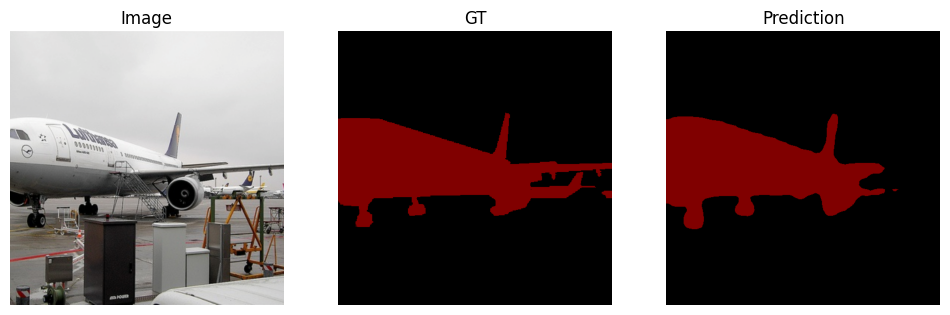

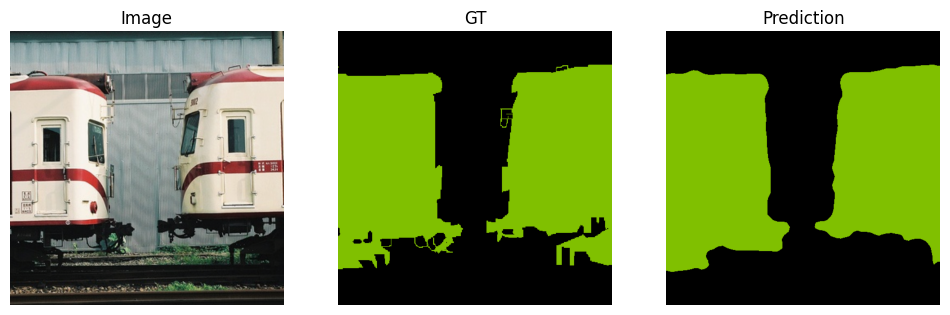

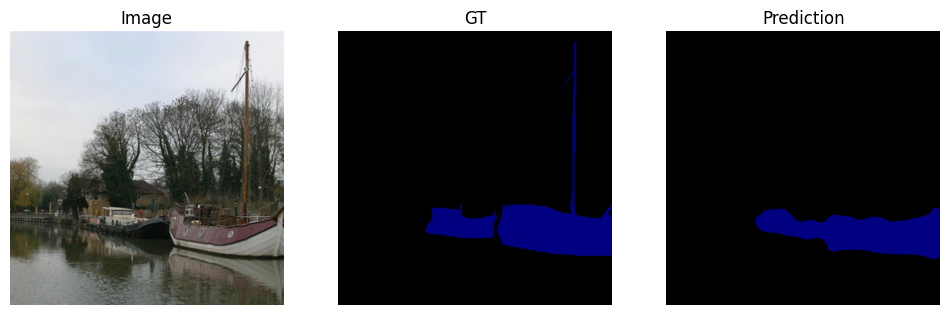

In [ ]:

# Visualize a few predictions
visualize_samples(3)
